# Рынок BMW

## Описание

Для простоты рассмотрим рынок BMW, выпущенных после 2010 года. Данные берутся с 3 наиболее популярных сайтов по продаже авто в России — Авто.ру, Авито, Дром

## Сбор данных

Так как каждый сайт имеет свой HTML-код, то код для парсинга каждого сайта будет отличаться. Используется динамический парсинг с помощью Selenium

### Основные критерии

- Модель
- Год выпуска
- Объем двигателя
- Бензин/дизель
- Привод
- Мощность (л.с.)
- Пробег
- КПП
- Цена
- Тип (седан/внедорожник/кроссовер) (???)


In [46]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
from urllib.parse import urlparse
import time
import re
import drom_parser
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

### Парсинг с Дрома

In [6]:
num_pages = 10                      # кол-во страниц, которые хоти обработать
year = 2010                         # самый ранний год выпуска машины
non_dymanic = True                 # если нужно, чтобы браузер НЕ открывался в явном виде, то поставить True

In [3]:
htmls = drom_parser.parse_html(year, num_pages, non_dymanic)

Error sending stats to Plausible: error sending request for url (https://plausible.io/api/event)


In [4]:
import importlib
import drom_parser
importlib.reload(drom_parser)
cars = drom_parser.collect_data(htmls)

In [5]:
for el in cars:
    print(el)

BMW X3, 2024 | X3 | 2024 | 50 |2.0L | 245 HP | бензин | 4WD | АКПП | 7600000 ₽ | https://auto.drom.ru/moscow-area/bmw/x3/561072744.html
BMW X2, 2019 | X2 | 2019 | 21400 |1.5L | 140 HP | бензин | передний | робот | 2540000 ₽ | https://auto.drom.ru/reutov/bmw/x2/423782337.html
BMW 1-Series, 2013 | 1-Series | 2013 | 51000 |1.6L | 136 HP | бензин | задний | АКПП | 1385000 ₽ | https://auto.drom.ru/krasnoyarsk/bmw/1-series/430987198.html
BMW 7-Series, 2019 | 7-Series | 2019 | 138610 |3.0L | 249 HP | дизель | 4WD | АКПП | 6750000 ₽ | https://auto.drom.ru/stavropol/bmw/7-series/902778714.html
BMW X4, 2023 | X4 | 2023 | 18028 |2.0L | 184 HP | бензин | 4WD | АКПП | 6992000 ₽ | https://auto.drom.ru/moscow/bmw/x4/310570881.html
BMW X1, 2012 | X1 | 2012 | 310000 |2.0L | 184 HP | дизель | 4WD | АКПП | 1320000 ₽ | https://auto.drom.ru/lezhnevo/bmw/x1/889617966.html
BMW X4, 2020 | X4 | 2020 | 63426 |3.0L | 249 HP | дизель | 4WD | АКПП | 5350000 ₽ | https://auto.drom.ru/moscow/bmw/x4/306799630.html
BMW

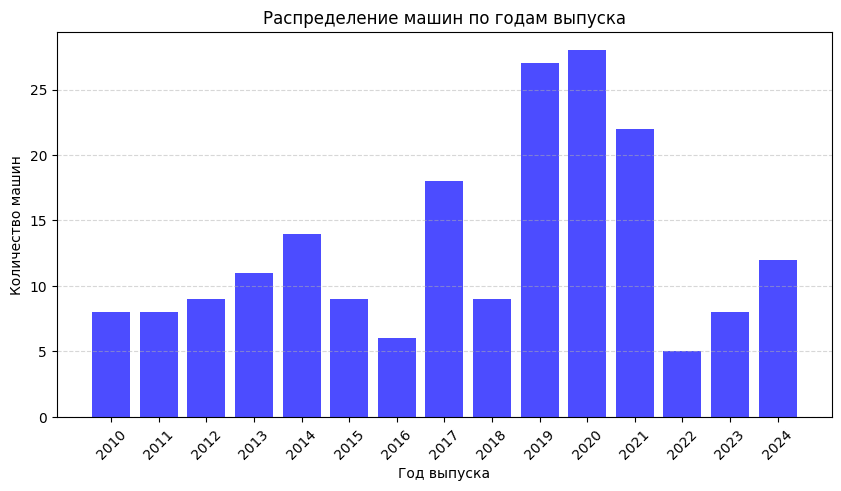

In [10]:
years = [car.year for car in cars]

year_counts = Counter(years)

x = sorted(year_counts.keys())
y = [year_counts[year] for year in x]

plt.figure(figsize=(10, 5))
plt.bar(x, y, color='blue', alpha=0.7)
plt.xlabel("Год выпуска")
plt.ylabel("Количество машин")
plt.title("Распределение машин по годам выпуска")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

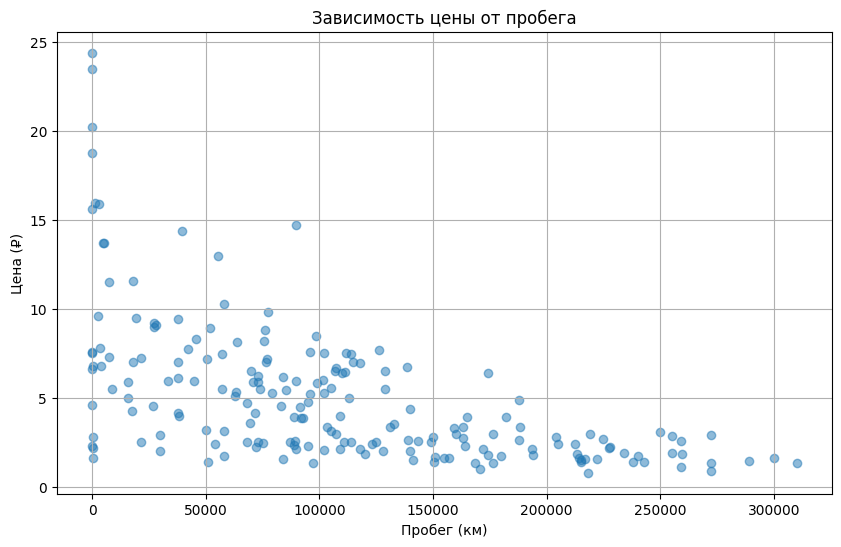

Корреляция между ценой и пробегом: -0.58


In [49]:
mileages = [car.mileage for car in cars]
prices = [car.price / 1000000 for car in cars]

plt.figure(figsize=(10, 6))
plt.scatter(mileages, prices, alpha=0.5)
plt.xlabel("Пробег (км)")
plt.ylabel("Цена (₽)")
plt.title("Зависимость цены от пробега")
plt.grid(True)
plt.show()

correlation = np.corrcoef(mileages, prices)[0, 1]

print(f"Корреляция между ценой и пробегом: {round(correlation, 2)}")

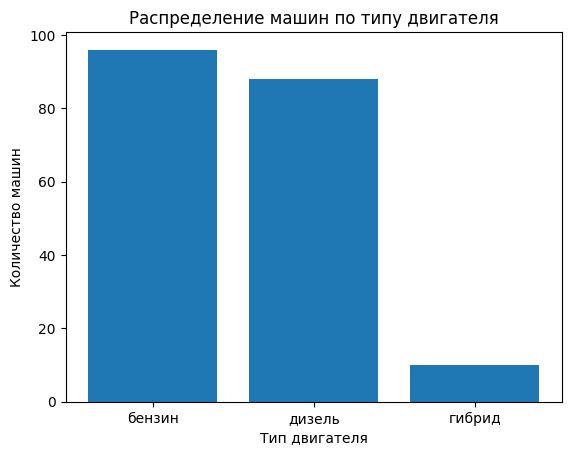

In [15]:
fuel_counts = Counter(car.fuel_type for car in cars)

plt.bar(fuel_counts.keys(), fuel_counts.values())
plt.xlabel("Тип двигателя")
plt.ylabel("Количество машин")
plt.title("Распределение машин по типу двигателя")
plt.show()

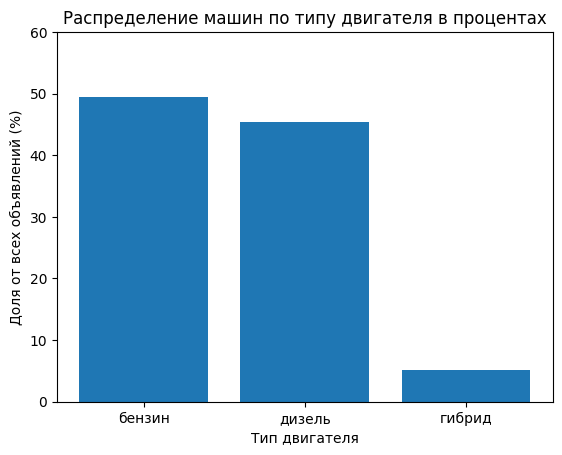

In [22]:
total_cars = len(cars)
fuel_counts = Counter(car.fuel_type for car in cars)
fuel_percentages = {key: (value / total_cars) * 100 for key, value in fuel_counts.items()}

plt.bar(fuel_percentages.keys(), fuel_percentages.values())
plt.xlabel("Тип двигателя")
plt.ylabel("Доля от всех объявлений (%)")
plt.title("Распределение машин по типу двигателя в процентах")
plt.ylim(0, 60)
plt.show()

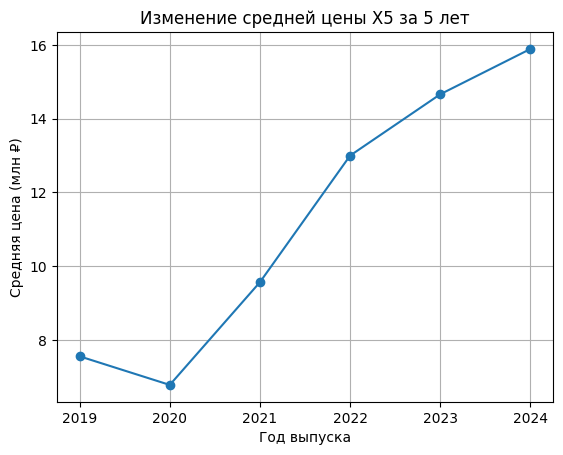

In [45]:
most_popular = Counter(car.gen for car in cars).most_common(1)[0][0]

filtered_cars = [car for car in cars if car.gen == most_popular]
years = sorted(set(car.year for car in filtered_cars if int(car.year) >= 2019))

avg_prices = [sum(car.price for car in filtered_cars if car.year == year) /
              sum(1 for car in filtered_cars if car.year == year) for year in years]
avg_prices = [price / 1_000_000 for price in avg_prices] 

plt.plot(years, avg_prices, marker='o')
plt.xlabel("Год выпуска")
plt.ylabel("Средняя цена (млн ₽)")
plt.title(f"Изменение средней цены {most_popular} за 5 лет")
plt.grid()
plt.show()


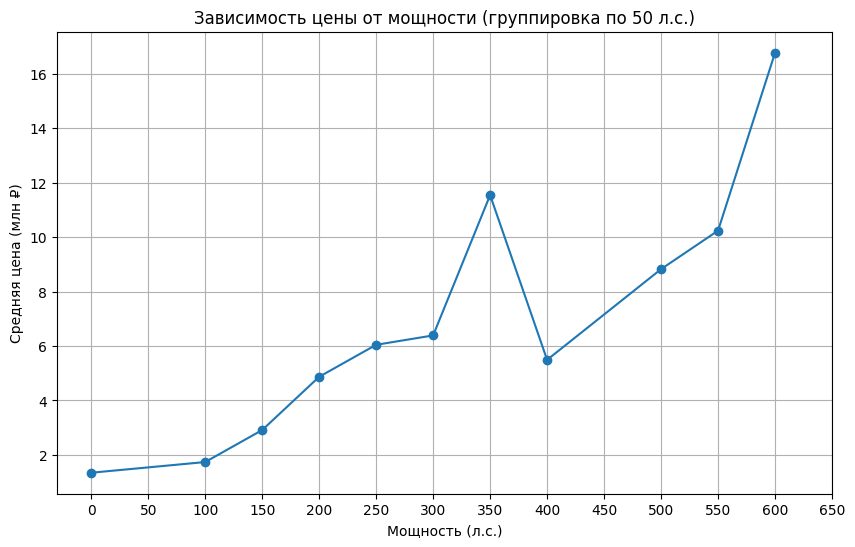

In [59]:
power_bins = range(0, max(int(car.power_hp) for car in cars) + 50, 50) # int(car.power_hp), потому что до этого там str был
# TODO: перезапустить код и убрать int(car.power_hp)

# Группируем данные
power_avg_price = {}
for power in power_bins:
    cars_in_bin = [car.price for car in cars if power <= int(car.power_hp) < power + 50]
    if cars_in_bin:
        power_avg_price[power] = sum(cars_in_bin) / len(cars_in_bin) / 1_000_000 

powers = sorted(power_avg_price.keys())
avg_prices = [power_avg_price[p] for p in powers]

plt.figure(figsize=(10,6))
plt.plot(powers, avg_prices, marker='o', linestyle='-')
plt.xlabel("Мощность (л.с.)")
plt.ylabel("Средняя цена (млн ₽)")
plt.title("Зависимость цены от мощности")
plt.grid()

plt.xticks(power_bins)  

plt.show()

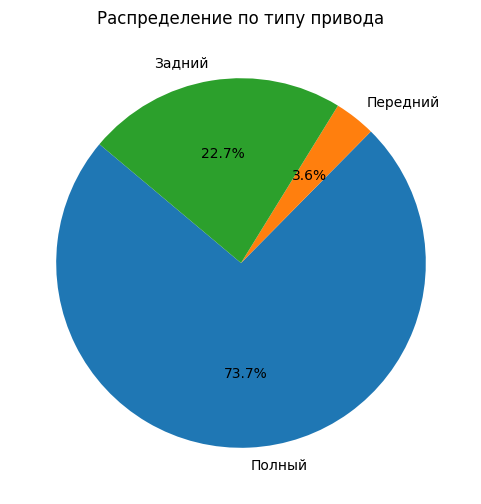

In [68]:
drive_mapping = {
    "передний": "Передний",
    "задний": "Задний",
    "4WD": "Полный"
}

drive_types = [drive_mapping.get(car.transmission, "Другой") for car in cars]
drive_counts = Counter(drive_types)

labels = drive_counts.keys()
sizes = drive_counts.values()

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Распределение по типу привода")
plt.show()